### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.utils.tensorboard import SummaryWriter
from scripts.data.dataset import DSLRDataset
from scripts.data.transforms import ToTensor, Normalize
from scripts.utils.load_save_models import save_checkpoint, get_latest_checkpoint, inference, load_checkpoint
from scripts.utils.visualizer import visualize_predictions, visualize_dataloader

# Set CUDA_LAUNCH_BLOCKING for accurate stack trace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()

# Set PYTORCH_CUDA_ALLOC_CONF to manage memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'



### Prepare for Dataset

In [2]:
# Paths to dataset and split files
data_dir = 'dataset/data'
train_split_file = 'dataset/splits/nvs_sem_train.txt'
val_split_file = 'dataset/splits/nvs_sem_val.txt'

# Define the transforms
transform = T.Compose([
    ToTensor(),
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Dataset

In [3]:
# Create datasets and dataloaders
train_dataset = DSLRDataset(data_dir, train_split_file, transform=transform)
val_dataset = DSLRDataset(data_dir, val_split_file, transform=transform)
# Get length of datasets
train_len = len(train_dataset)
val_len = len(val_dataset)
print('Train dataset length:', train_len)
print('Val dataset length:', val_len)


# create a random index
idx = torch.randint(0, train_len, (1,)).item()
sample = train_dataset[idx]
print(f'Random sample shape: {idx}', sample['depth'].shape)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)


# check if the dataloader's shapes are correct, including the batch size

print('Train dataloader shape:', next(iter(train_loader))['image'].shape)
print('Val dataloader shape:', next(iter(val_loader))['image'].shape)




Train dataset length: 4
Val dataset length: 4
Random sample shape: 0 torch.Size([448, 672])
Train dataloader shape: torch.Size([2, 3, 448, 672])
Val dataloader shape: torch.Size([1, 3, 448, 672])


### Visualize first

Visualizing data from the dataloader...
Loaded palette: [[0.40784314 0.8        1.        ]
 [0.7372549  0.74117647 0.13333333]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.83921569 0.15294118 0.15686275]]
Input image shape: (448, 672, 3), min: 0.0, max: 1.0
Label image shape: (448, 672), unique values: [-100   -1    0    2    3    4    9   55   70]
Input image shape: (448, 672, 3), min: 0.0, max: 1.0
Label image shape: (448, 672), unique values: [-100   -1    0    2    3    5    6    7    9   15   17   28   43   56
   61   65   84]


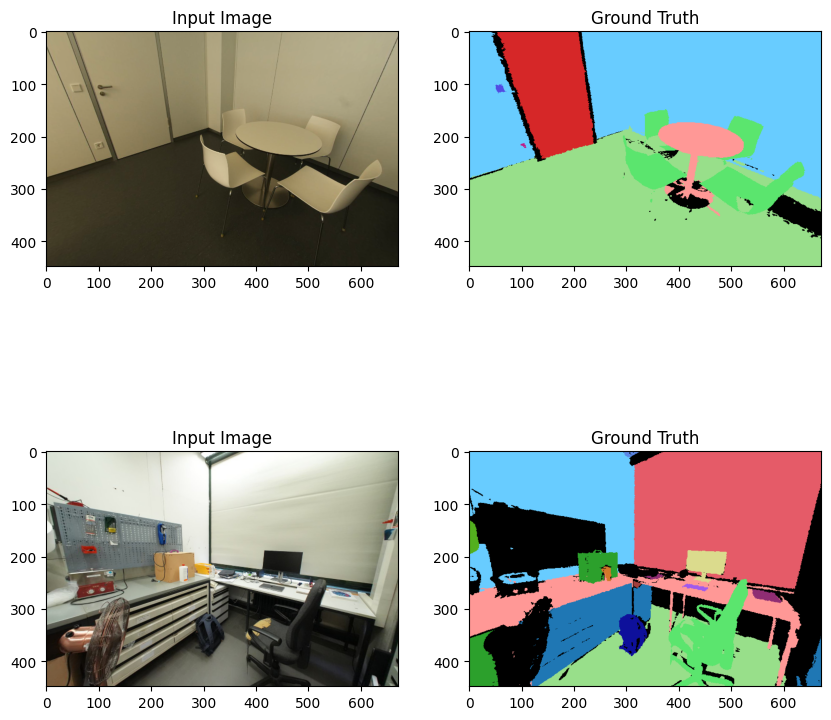

In [4]:
# Visualize data from the dataloader before training
print("Visualizing data from the dataloader...")
visualize_dataloader(val_loader, palette_file='scripts/utils/palette_scannet200.txt', num_samples=2)

### Training preparation

In [5]:
from scripts.networks.nn_2d import MobileNetV3_Segmentation
from scripts.networks.nn_2d_dino import DINOv2_Segmentation
from scripts.networks.nn_2d_segformer import Segformer_Segmentation

# Clear GPU cache
torch.cuda.empty_cache()
# Instantiate the model and move it to the device: SegFormer

model = Segformer_Segmentation(num_classes=101)

# model to device
model = model.to(device)



# Define the ignore index for invalid labels
IGNORE_INDEX = -1

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 

# Check the model architecture
print(model)
# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='./runs')


/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Segformer_Segmentation(
  (backbone): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )


### Load the latest

In [6]:
from scripts.utils.load_save_models import get_latest_checkpoint
# Create the checkpoints directory
checkpoint_dir = './checkpoints'

# Load latest checkpoint if available
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
start_epoch = 0
if latest_checkpoint:
    start_epoch, _ = load_checkpoint(latest_checkpoint, model, optimizer)
    print(f"Resuming training from epoch {start_epoch}")


Resuming training from epoch 1000


### Train loop

In [7]:
import torch
import torch.nn.functional as F
from scripts.networks.utils_projection import project_to_3d, apply_softmax, colorize_point_cloud, save_point_cloud_to_ply,load_palette


# 定义计算准确率的函数
def calculate_accuracy(outputs, labels, ignore_index):
    # 获取预测的标签
    preds = torch.argmax(outputs, dim=1)
    valid_mask = labels != ignore_index
    correct = torch.sum(preds[valid_mask] == labels[valid_mask]).item()
    total = torch.sum(valid_mask).item()
    return correct / total if total > 0 else 0

# Training loop
num_epochs = 2000
save_interval = 10  # Save a checkpoint every 10 epochs

for epoch in range(start_epoch, num_epochs):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    for i, images in enumerate(train_loader):
        inputs = images['image'].to(device)
        labels = images['label'].to(device)
        ##############################################
        #这里可以加入相机的内参外参
        depth = images['depth'].to(device)
        R = images['R'].to(device)
        R_2 = images['R'].to(device)
        assert torch.equal(R, R_2)
        T = images['T'].to(device)
        K = images['intrinsic_mat'].to(device)
        
        # Identify invalid labels and set them to IGNORE_INDEX
        invalid_mask = (labels < 0)
        labels[invalid_mask] = IGNORE_INDEX
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        # Project 2D features to 3D space
        point_cloud_features = project_to_3d(outputs, depth, K, R, T, ignore_index=IGNORE_INDEX)
        # print('Point cloud features shape:', point_cloud_features.shape) # (B, N, 3 + C_classes)
        
        ###################################################
        ################TODO：3D网络从这里接入################
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        # 这里是用来检测点云是否生成正确，正式运行的时候可以注释掉
        # Apply softmax and convert to integer predictions
        point_cloud_with_predictions = apply_softmax(point_cloud_features)
        palette = load_palette('scripts/utils/palette_scannet200.txt')
        # Colorize point cloud using the predictions and palette
        point_cloud_with_colors = colorize_point_cloud(point_cloud_with_predictions, palette)

        # Save the colored point cloud to PLY files
        save_point_cloud_to_ply(point_cloud_with_colors, './outputs')
        
        
        
        ###################END OF TODO#######################
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # 计算准确率
        corrects = calculate_accuracy(outputs, labels, IGNORE_INDEX)
        running_corrects += corrects * inputs.size(0)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {epoch_acc}")

    # Log training loss and accuracy to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)
    writer.add_scalar('Training Accuracy', epoch_acc, epoch)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0
    with torch.no_grad():
        for i, images in enumerate(val_loader):
            inputs = images['image'].to(device)
            labels = images['label'].to(device)
            
            ############TODO: 根据train同理修改这一部分############ 
            
            invalid_mask = (labels < 0)
            labels[invalid_mask] = IGNORE_INDEX
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            
            ###############END OF TODO##########################
            # 计算准确率
            corrects = calculate_accuracy(outputs, labels, IGNORE_INDEX)
            val_corrects += corrects * inputs.size(0)
            val_samples += inputs.size(0)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = val_corrects / val_samples
    print(f"Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_acc}")

    # Log validation loss and accuracy to TensorBoard
    writer.add_scalar('Validation Loss', epoch_val_loss, epoch)
    writer.add_scalar('Validation Accuracy', epoch_val_acc, epoch)

    # Save a checkpoint
    if (epoch + 1) % save_interval == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch + 1, model, optimizer, epoch_loss, checkpoint_dir, filename=f'checkpoint_epoch_{epoch+1}.pth.tar')

print("Training complete")
writer.close()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Point cloud saved to ./outputs/point_cloud_0.ply
Point cloud saved to ./outputs/point_cloud_1.ply
Point cloud saved to ./outputs/point_cloud_0.ply
Point cloud saved to ./outputs/point_cloud_1.ply
Epoch [1001/2000], Loss: 1.6302290260791779, Accuracy: 0.7614215143427675
Validation Loss: 0.775287751108408, Validation Accuracy: 0.7941736665316417
Point cloud saved to ./outputs/point_cloud_0.ply
Point cloud saved to ./outputs/point_cloud_1.ply


### Inference and visualizations

Label shape: torch.Size([1, 448, 672]), unique values: tensor([-100,   -1,    0,    1,    2,    3,    6,    8,    9,   14,   16,   21,
          24,   27,   48,   55,   56,   61,   70,   93], device='cuda:0')
Output shape: torch.Size([1, 101, 448, 672]), unique values: tensor([-27.7663, -27.7263, -27.6891,  ...,  27.0422,  27.0661,  27.0822],
       device='cuda:0')
Label shape: torch.Size([1, 448, 672]), unique values: tensor([-100,   -1,    0,    2,    3,    5,    6,    7,    9,   15,   17,   28,
          43,   56,   61,   65,   84], device='cuda:0')
Output shape: torch.Size([1, 101, 448, 672]), unique values: tensor([-27.0627, -27.0335, -26.9583,  ...,  21.8284,  21.8522,  21.8668],
       device='cuda:0')
Predictions shape: torch.Size([1, 101, 448, 672])
Predictions: [tensor([[[[ 1.6674,  1.6674,  1.6964,  ...,  9.0815,  8.9873,  8.9873],
          [ 1.6674,  1.6674,  1.6964,  ...,  9.0815,  8.9873,  8.9873],
          [ 1.6636,  1.6636,  1.6904,  ...,  9.2167,  9.1311,  9.1311],


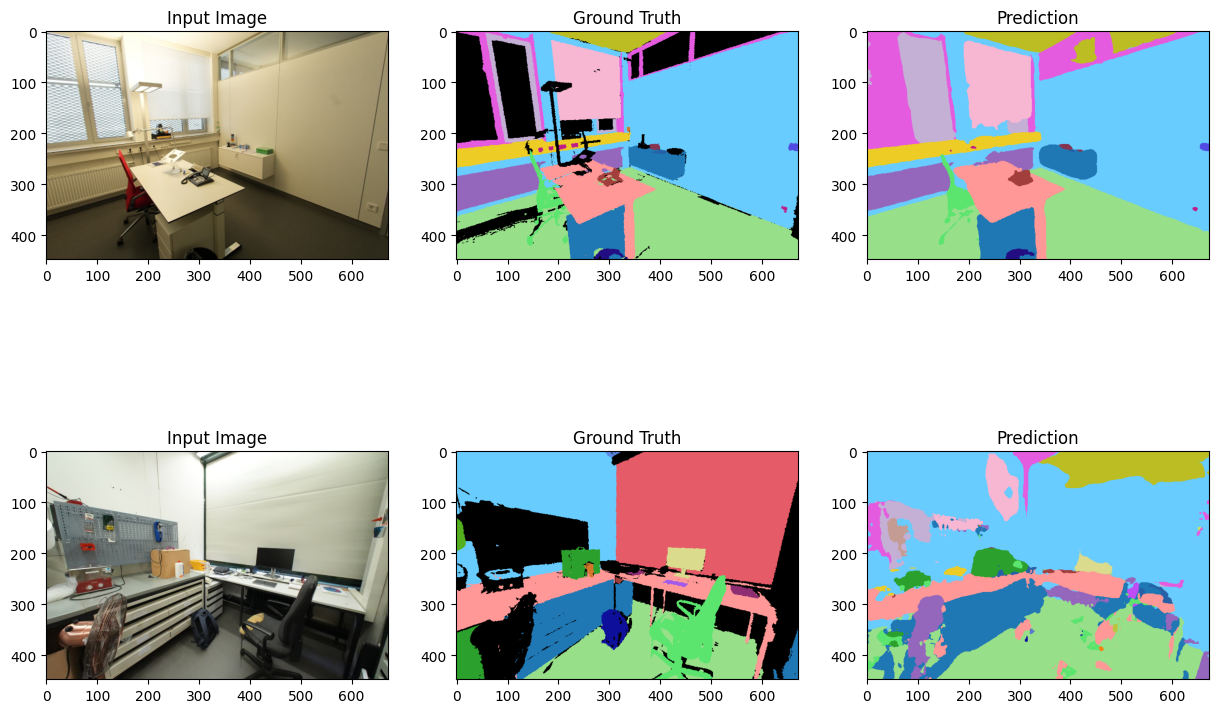

In [ ]:
# Inference and visualize predictions
inference_checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_830.pth.tar')
inputs, labels, predictions = inference(model, val_loader, device, num_samples=2)
# Get the tensor inside the prediction
print('Predictions shape:', predictions[0].shape)
print('Predictions:', predictions)

visualize_predictions(inputs, labels, predictions, palette_file='scripts/utils/palette_scannet200.txt')